## Confidence intervals for system evaluation using the bootstrapping approach

This notebook contains the code needed to create confidence intervals with the bootstrapping approach
for (almost) any task, dataset or metric. Four things are required to run this code:

* **Samples**: an array that can be indexed to select the samples for each bootstrap set. Note that, here, the term sample refers to ``whatever is needed to compute the metric of interest''. This will generally be the system's output (scores or decisions). Yet, for metrics that are simple averages of some per-sample loss, the sample can simply be represented by the per-sample loss (more on this below).
* **Labels**: an array that can be indexed to select the labels, or any other information needed to compute the metric, for the samples above.
* **Conditions**: an array of integers indicating the conditions of the samples (e.g., the speaker identity). All samples with the same condition will be sampled together when doing bootstrapping.
* **Metric**: The metric to be used for assessing performance. A method that takes samples and, when necessary, labels and computes a scalar value. 
  
The metric, samples, and labels can be as simple or as complex as your task requires. The table below shows some examples on how the different inputs may be defined. 


<center>

| Task                         | Metric           | Sample                              | Label             |  Condition        |
|------------------------------|------------------|-------------------------------------|-------------------|-------------------|
| Emotion classification       | Accuracy         | System's decision                   | Emotion label     | Speaker           |
| Emotion classification       | Accuracy         | 0 or 1 (correct/incorrect decision) | -                 | Speaker           |
| Speaker verification         | EER              | System's score for trial            | Target/Impostor   | See comment below |
| Automatic speech recognition | Av. WER          | Per-sample WER                      | -                 | Speaker           |
| Automatic speech recognition | Weighted Av. WER | Per-sample WER                      | Num words         | Speaker           |
| Diarization                  | Weighted Av. DER | Per-sample DER                      | Num speech frames | Speaker           |

</center>

Some notes:

* For metrics that are averages of some loss over the samples like the accuracy, or the average WER, the sample can be represented directly by the per-sample loss, the metric is simply the average of the loss over the samples, and the label is not needed.
* For the weighted average WER and DER metrics often used for ASR and diarization, where the weights are given by the number of words in each sample or the number of speech frames, respectively, the label field can be used to provide the number of words or speech frames for each sample so that the metric can be computed from the individual WER or DER values and this quantity (see example below).
* While for speech tasks the speaker is the most common correlation-inducing factor, other factors may exist, like the recording session (if more than one sample is generated in a session) or the original waveform (if samples are waveform chunks extracted from longer waveforms).
* In speaker verification, bootstrapping by condition is harder than for other tasks because both sides in a trial (the enrollment and the test side) have their own condition. The code in this repository cannot handle this particular case. Instead, joint bootstrapping is needed. Please see the code in the [DCA-PLDA github repository](https://github.com/luferrer/DCA-PLDA/blob/master/dca_plda/scores.py) (compute_performance_with_confidence_intervals method) for an example of how to do joint bootstrapping for speaker verification.  


In [1]:
pip install git+https://github.com/luferrer/ConfidenceIntervals.git

  Cloning https://github.com/luferrer/ConfidenceIntervals.git to /private/var/folders/yc/gnzvhlcn0g1gb0kjw3nnj4t80000gn/T/pip-req-build-50vmeskc
  Running command git clone --filter=blob:none --quiet https://github.com/luferrer/ConfidenceIntervals.git /private/var/folders/yc/gnzvhlcn0g1gb0kjw3nnj4t80000gn/T/pip-req-build-50vmeskc
  Resolved https://github.com/luferrer/ConfidenceIntervals.git to commit 2b3fcc8af89a5ac617ab2bb8bc5e84675fc44713
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import sklearn.metrics
from confidence_intervals import evaluate_with_conf_int
from confidence_intervals.utils import create_data

In [3]:
# Create a toy dataset. Here the samples are simply the decisions made by the system.
N0 = 200
N1 = 200
NC = 20
decisions, labels, conditions = create_data(N0, N1, NC, scale=1.0)

# Percentage for the confidence interval
alpha = 5 

# Number of bootstrap samples to use (the run time will be proportional to this number). We set it to
# 50/alpha to get enough samples in the tails.
num_bootstraps = int(50/alpha)



Below we show the simplest way to obtain both the metric on the complete dataset and the confidence interval, in a single line of code.


In [4]:
metric =  sklearn.metrics.accuracy_score
evaluate_with_conf_int(labels, decisions, metric, conditions, num_bootstraps=num_bootstraps, alpha=alpha)


(0.855, (0.8218000845180959, 0.8952843516058924))

Alternatively, as mentioned in the introduction, one can compute the accuracy as the average of the 0-1 loss. In this case, we need to set the first argument to None, define the second argument as the 0-1 loss, and the metric as the mean. 

This same approach can be used for ASR or diarization where the metric is an average of per-sample losses that are not quick to compute. In that case, the samples array should contain the per-sample losses, replacing the 0-1 loss used below. 

In [5]:
samples = decisions == labels
evaluate_with_conf_int(None, samples, np.average, conditions, num_bootstraps=num_bootstraps, alpha=alpha)

(0.855, (0.8218000845180959, 0.8952843516058924))

In some cases, the metric is a weighted average of per-sample losses. In that case, the labels array can be used to provide the weight to the metric, which can be defined as below.

In [6]:
samples = decisions == labels

# Setting all the weights to 1, the metric is the accuracy, as above. 
weights = np.ones_like(samples)

def metric(weights, samples):
    return np.average(samples, weights=weights)

evaluate_with_conf_int(weights, samples, metric, conditions, num_bootstraps=num_bootstraps, alpha=alpha)

(0.855, (0.8218000845180959, 0.8952843516058924))

The block below shows the few lines of code needed to run bootstrapping, unwrapping evaluate_with_conf_int. This shows how straightforward the approach is. The only somewhat complex step is inside the get_bootstrap_indices method for the case that involves conditions. 

You can use this as pseudo-code if, for example, you need to recode bootstrapping in some other language or compute a more involved metric that does not take only samples and labels as input.

In [7]:
from confidence_intervals import get_bootstrap_indices, get_conf_int

metric =  sklearn.metrics.accuracy_score
metric_values = []
num_samples = len(decisions)
for nb in np.arange(num_bootstraps):
    indices = get_bootstrap_indices(num_samples, conditions=conditions, random_state=nb)
    metric_values.append(metric(labels[indices], decisions[indices]))

print(metric(labels, decisions), get_conf_int(metric_values, alpha))




0.855 (0.8218000845180959, 0.8952843516058924)


Below is an example on how to create a bar plot for two systems, with and without using conditions.

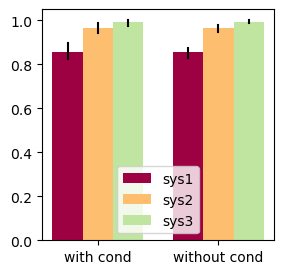

In [8]:
from confidence_intervals.utils import barplot_with_ci
metric =  sklearn.metrics.accuracy_score

# The create_data method generates the same labels and conditions for all three cases below. 
# Only the decisions change, simulating three different systems.
decisions = {}
decisions['sys1'], labels, conditions = create_data(N0, N1, NC, scale=1.0)
decisions['sys2'], labels, conditions = create_data(N0, N1, NC, scale=0.5)
decisions['sys3'], labels, conditions = create_data(N0, N1, NC, scale=0.3)

data = {}
for sys, dec in decisions.items():
   val_with_cond = evaluate_with_conf_int(labels, dec, metric, conditions, num_bootstraps=num_bootstraps, alpha=alpha)
   val_no_cond   = evaluate_with_conf_int(labels, dec, metric, None,       num_bootstraps=num_bootstraps, alpha=alpha)
   data[sys] = {'with cond': val_with_cond, 'without cond': val_no_cond}

barplot_with_ci(data, figsize=(3,3))


Finally, we show how to create a confidence interval for comparing the performance between two of the systems above. Since the metric needed for this case is a bit more involved than what the evaluate_with_conf_int method can handle, we use the unwrapped code already shown above.

**If the confidence interval does not include the value 0.0, then we can reject the null hypothesis that the two systems have the same performance (see Keller, 2005, cited in the README file).**

In [18]:
from confidence_intervals import get_bootstrap_indices, get_conf_int

base_metric =  sklearn.metrics.accuracy_score

def metric(labels, dec1, dec2):
    return base_metric(labels, dec2) - base_metric(labels, dec1)

metric_values = []
num_samples = len(decisions['sys1'])
for nb in np.arange(num_bootstraps):
    indices = get_bootstrap_indices(num_samples, conditions=None, random_state=nb)
#    indices = get_bootstrap_indices(num_samples, conditions=conditions, random_state=nb)
    metric_values.append(metric(labels[indices], decisions['sys3'][indices], decisions['sys2'][indices]))

print(metric(labels, decisions['sys1'], decisions['sys2']), get_conf_int(metric_values, alpha))


0.10999999999999999 (-0.04750000000000007, -0.015312500000000052)
